In [16]:
include("../Inversion/Plot.jl")
include("Linear.jl")
include("../Inversion/KalmanInversion.jl")

EKI_Run (generic function with 1 method)

# High Dimensional Bernoulli Problem

Consider the following artificial inverse problem 
\begin{equation*}
\begin{split}
y = G\theta + \eta, \\
\end{split}
\end{equation*}
with $G = I\in\mathcal{R}^{N_{y} \times N_{\theta}}$ and $N_{y} = 1000\,,\,N_{\theta} = 1000$. 
The entries of the underlying truth $\theta_{ref}$ are independent, identical Bernoulli distribution $B(1, 0.5)$. The observation is $y = G\theta_{ref}$, with observation error $\eta \sim \mathcal{N}(0,I)$. 

In [17]:
function Bernoulli(N_θ::Int64)    
    
    G = I
    
    θ_ref = Float64.(rand(Binomial(1, 0.5), N_θ))
    y = G*θ_ref
     
    Σ_η = Diagonal(fill(1.0^2, N_θ))
    
    return θ_ref, G, y, Σ_η
end

Bernoulli (generic function with 1 method)

## Truncated Unscented Kalman Inversion

However, there is no low-rank covariance structure information. Hence, the initial distribution is set to be $\N(0,  \I)$. 
Although there is no low-rank covariance structure information, the TUKI is applied, with truncated rank $N_r = 5$.
EKI, EAKI, and ETKI are also applied with the ensemble size of $J= 2N_r+1$.


The convergence of $\{m_n\}$ in terms of the relative $L_2$ norm errors is depicted. All EKI, EAKI, ETKI diverge and TUKI fail to converge to $\theta_{ref}$. (When the artificial covariance matrix $\Sigma_{\omega}$ is used instead of the truncated square-root covariance matrix $Z_{\omega}$ in Ensemble-based Kalman inversion, all of them diverge.)

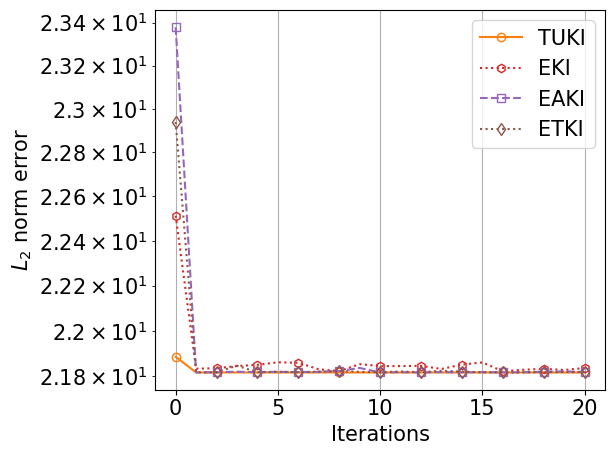

In [18]:
N_θ = 1000
θ_ref, G, y, Σ_η = Bernoulli(N_θ)

N_y = length(y)

s_param = Setup_Param(G, N_θ, N_y)

θ0_mean = zeros(Float64, N_θ)  # mean 

α_reg = 1.0
update_freq = 0
N_iter = 20
N_r = 5
N_ens = 2N_r + 1

# truncate the inital covariance matrix and the corresponding artificial evoluation matrix

θθ0_cov_sqrt = Array(Diagonal(fill(10.0, N_θ)))[: ,1:N_r]


# EKI 
ekiobj = EKI_Run(s_param, forward, 
"EKI",
θ0_mean, θθ0_cov_sqrt,
N_ens,
y, Σ_η,
α_reg,
update_freq,
N_iter)


# EAKI
eakiobj = EKI_Run(s_param, forward, 
"EAKI",
θ0_mean, θθ0_cov_sqrt,
N_ens,
y, Σ_η,
α_reg,
update_freq,
N_iter)

# ETKI
etkiobj = EKI_Run(s_param, forward, 
"ETKI",
θ0_mean, θθ0_cov_sqrt,
N_ens,
y, Σ_η,
α_reg,
update_freq,
N_iter)

# Truncated Unscented Kalman inversion
tukiobj = TUKI_Run(s_param, forward, 
θ0_mean, θθ0_cov_sqrt,
y, Σ_η,
α_reg,
update_freq,
N_iter)


ites = Array(LinRange(0, N_iter, N_iter+1))
errors = zeros(Float64, (4, N_iter+1))
for i = 1:N_iter+1
    errors[1, i] = norm(dropdims(mean(ekiobj.θ[i], dims=1), dims=1) .- θ_ref)
    errors[2, i] = norm(dropdims(mean(eakiobj.θ[i], dims=1), dims=1) .- θ_ref)
    errors[3, i] = norm(dropdims(mean(etkiobj.θ[i], dims=1), dims=1) .- θ_ref)
    errors[4, i] = norm(tukiobj.θ_mean[i] .- θ_ref)
end


markevery = max(div(N_iter, 10),1)


semilogy(ites, errors[4, :], "-o", color="C1", fillstyle="none", markevery=markevery, label= "TUKI")
semilogy(ites, errors[1, :], ":h",  color="C3", fillstyle="none", markevery=markevery, label= "EKI")
semilogy(ites, errors[2, :], "--s",  color="C4", fillstyle="none", markevery=markevery, label= "EAKI")
semilogy(ites, errors[3, :], ":d",  color="C5", fillstyle="none", markevery=markevery, label= "ETKI")


xlabel("Iterations")
ylabel("\$L_2\$ norm error")
#ylim((0.1,15))
grid("on")
legend()
tight_layout()